In [1]:
import torch
from torch import nn
from torchvision import transforms
import torchvision
import time
import os
from IPython import display
from torch.nn import functional as F
from matplotlib import pyplot as plt
%matplotlib inline
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [2]:
def resnet18(num_classes, in_channels=1):
    def resnet_block(in_channels, out_channels, num_residuals,
                    first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(
                Residual(in_channels, out_channels, use_1x1conv=True,
                        strides=2))
            else:
                blk.append(Residual(out_channels, out_channels))
        return nn.Sequential(*blk)
    
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64), nn.ReLU()
    )
    net.add_module('resnet_block1', resnet_block(64, 64, 2, first_block=True))
    net.add_module('resnet_block2', resnet_block(64, 128, 2))
    net.add_module('resnet_block3', resnet_block(128, 256, 2))
    net.add_module('resnet_block4', resnet_block(256, 512, 2))
    net.add_module('global_avg_pool', nn.AdaptiveAvgPool2d((1, 1)))
    net.add_module('fc', 
                  nn.Sequential(nn.Flatten(), nn.Linear(512, num_classes)))
    return net

In [3]:
class Residual(nn.Module):

    def __init__(self, input_channels, num_channels, use_1x1conv=False,
                 strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3,
                               padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3,
                               padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)
    
def try_all_gpus():
    devices = [
        torch.device(f'cuda:{i}') for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

In [4]:
net = resnet18(10)
device = try_all_gpus()

In [5]:
def train(net, num_gpus, batch_size, lr):
    train_iter, test_iter = load_data_fashion_mnist(batch_size)
    devices = [try_gpu(i) for i in range(num_gpus)]

    def init_weights(m):
        if type(m) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(m.weight, std=0.01)

    net.apply(init_weights)
    net = nn.DataParallel(net, device_ids=devices)
    trainer = torch.optim.SGD(net.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    timer, num_epochs = Timer(), 10
    animator = Animator('epoch', 'test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for x, y in train_iter:
            trainer.zero_grad()
            x, y = x.to(devices[0]), y.to(devices[0])
            l = loss(net(x), y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(epoch + 1, (evaluate_accuracy_gpu(net, test_iter),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch'
          f'on {str(devices)}')

In [6]:
from torch.utils import data
def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="../../data",
                                                    train=True,
                                                    transform=trans,
                                                    download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="../../data",
                                                   train=False,
                                                   transform=trans,
                                                   download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

def get_dataloader_workers():
    return 4

class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        self.config_axes = lambda: set_axes(self.axes[
                                                0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
        
def use_svg_display():
    display.set_matplotlib_formats('svg')
    
class Timer:
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        self.tik = time.time()

    def stop(self):
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        return sum(self.times) / len(self.times)

    def sum(self):
        return sum(self.times)

    def cumsum(self):
        return np.array(self.times).cumsum().tolist()

def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()
            
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, torch.nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(accuracy(net(X), y), size(y))
    return metric[0] / metric[1]

class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = argmax(y_hat, axis=1)
    cmp = astype(y_hat, y.dtype) == y
    return float(reduce_sum(astype(cmp, y.dtype)))

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
    
def try_gpu(i=0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')


argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)

test acc: 0.93, 55.9 sec/epochon [device(type='cuda', index=0)]


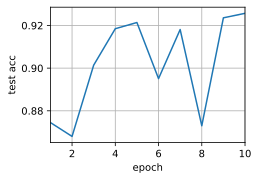

In [7]:
train(net, num_gpus=1, batch_size=128, lr=0.1)

test acc: 0.90, 46.5 sec/epochon [device(type='cuda', index=0)]


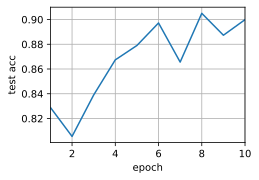

In [8]:
train(net, num_gpus=1, batch_size=256, lr=0.2)